In [1]:
import os

os.chdir("..")

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

from src.link_prediction.HierarchicalStructureModel import HSM
from src.link_prediction.StochasticBlockModel import SBM
from src.link_prediction.SimilarityPredictor import SimilarityPredictor
from src.link_prediction.similarity_metrics import *
from src.utils.viz import plot_graph, plot_predicted_graph
from src.utils.statistics import Stats

# Link Prediction in Python
In this notebook, we will show how to use the link prediction methods implemented in `src/link_prediction/` and give a brief overview of the inner workings of the algorithms.

In its simplest form, link prediction is about predicting the probability a link $(i,j)$ is part of the real graph $G=(V^O,E)$ given some observed graph $G^O=(V^O, E^O)$: $P((i,j)\in E | G^O)$. There are multiple ways to approach this. 

Maximum-likelihood methods introduce some null-model $\mathcal{M}$ and condition the probability as follows: $P((i,j)\in E | G^O, \mathcal{M}) \cdot P(\mathcal{M} | G^O)$. Since we cannot compute all possible instances of $\mathcal{M}$, for any non-trivial null-model, ML methods use MCMC sampling to sample from the distribution $P(\mathcal{M})$.

Similarity-based methods construct a metric $S$ that computes the similarity between two nodes. Local similarity-based methods compare nodes $i,j$ based on only their direct neighbors; simple, but not as expressive. Global similarity-based methods compare the entire graph, and determine the similarity on more global properties; expressive but expensive. Somewhere between the two extremes, quasi-local methods strike a balance between expressiveness and complexity, by considering a 'ball' of influence around both nodes. This relatively simple approach to link prediction can be very successful.


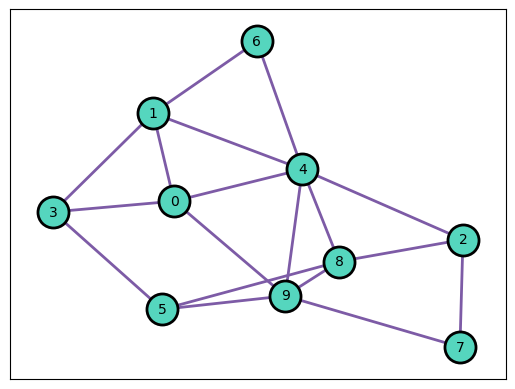

In [4]:
G = nx.erdos_renyi_graph(10, 0.3)
plot_graph(G)

## Hierarchical Structure Model

The HSM assumes that a network can be decomposed hierarchically. More formally, the HSM [1] samples Dendrograms $D$ according to their likelihood $\mathcal{L}(D)$. A Dendrogram is a type of binary tree, where the leaves are the nodes $V$ of an observed graph $G^O$ and the internal nodes $r$ each have a probability $p_r$. $p_r$ is the probability that a node in the left subtree is connected to a node in the right subtree $p_r$. Thereby, $p_r = \frac{1}{Lr * Rr} \Sigma_{u,v} \mathbf{1}[(u,v) \in G)$ where $Lr$, $Rr$ are the nodes in the left and right subtree respectively, $u$ is a node in the left subtree, and $v$ is a node in the right subtree. 

To compute the likelihood of the dendrogram, $\mathcal{L}(D) = \prod_{(i,j)\in G} \left[ (p_{ij})^{p_{ij}} \cdot (1-p_{ij})^{p_{ij}} \right] ^ {Lr \cdot Rr}$ using $p_{ij} = p_r$ where $r$ is the lowest common ancestor of $(i,j)$. [1] implements a Metropolis-Hastings algorithm for sampling $D$ according to their likelihood $\mathcal{L}(D)$. After a burn-in period, dendrograms are sampled by randomly swapping a subtree $u$ of a random node $r$ with its sibling $v$ to create a new dendrogram $D'$. If the log likelihood of $D'$, $\log \mathcal{L}(D')$ is greater than the log likelihood of $D$, $D'$ becomes the new dendrogram. Otherwise, to promote exploration, the alternate dendrogram $D'$ is accepted with a probability of $\mathcal{L}(D') / \mathcal{L}(D)$.

After sampling some dendrograms $\mathbf{D}$, we can estimate the reliability of a missing link $R(i,j)$ by computing the mean probability according to the dendrogram samples: $R(i,j) = \frac{1}{N} \Sigma_{D\in\mathbf{D}} p_{ij}(D)$ where $p_{ij}(D)$ is the probability of $(i,j)\in G$ according to dendrogram $D$. 

In the following example, we select the top 3 links and add them to the graph.

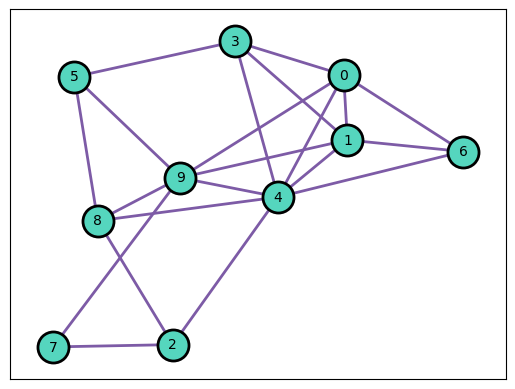

In [5]:
nG = HSM().add_top_k_links(G, 3)
plot_graph(nG)

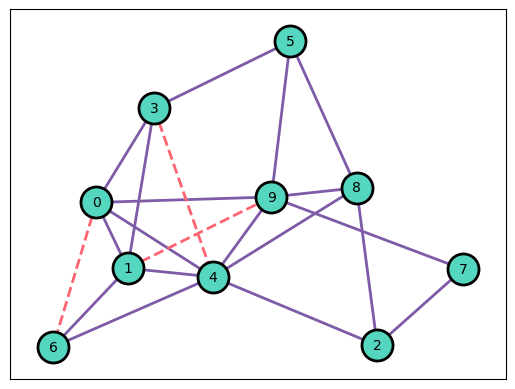

In [6]:
plot_predicted_graph(G, nG)

## Maximum-likelihood estimation with SBM null model
Instead of assuming a hierarchical structure, we can also use the Stochastic Block Model as null model [2]. This assumption specifies that the network is structured in groups, and the probability of two nodes $i,j$ being connected only depends on the groups they belong to $\sigma_i, \sigma_j$: $p_{ij} = p_{\sigma_i\sigma_j}$. Instead of sampling dendrograms, the ML-SBM method samples partitions $P$ of the set of nodes $V$ such that every node $u$ in $V$ is assigned to exactly one group.

The likelihood of a partition $\mathcal{L}(P)=\prod_{\alpha\leq\beta} p_{\alpha\beta}^{l_{\alpha\beta}} \cdot (1-p_{\alpha\beta})^{(r_{\alpha\beta}-l_{\alpha\beta})}$ where $r_{\alpha\beta}$ are the possible links between groups $\alpha$,$\beta$ and $l_{\alpha\beta}$ are the observed links between groups $\alpha, \beta$. Similar to before, partitions are sampled according to their likelihood using the Metropolis-Hastings algorithm. Now, we create an alternate partition $P'$ by moving one node to a different group. We accept the transition if $\mathcal{L}(D') \geq \mathcal{L}(D)$. Otherwise, we accept the transition with a probability of $\exp(- \Delta \mathcal{L})$.

In the following example, we add the top 3 most likely links to the graph.

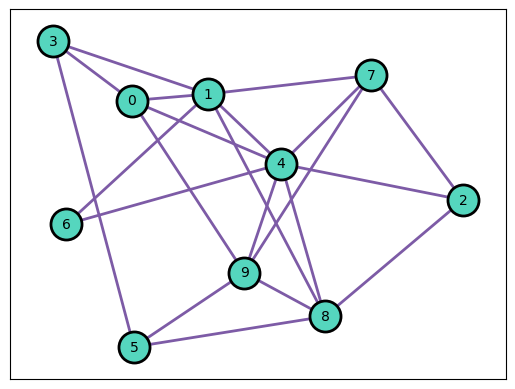

In [14]:
nG = SBM().add_top_k_links(G, 3)
plot_graph(nG)

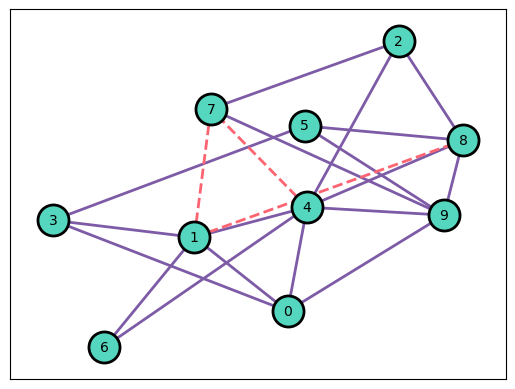

In [15]:
plot_predicted_graph(G, nG)

## Similarity-based link prediction
A simpler approach for link prediction is to classify a link $(i,j)$ as missing if $(i,j)\notin G^O$ and $S(i,j) \geq t$, where $S(i,j)$ is a similarity metric between two nodes $i,j$ and $t$ is a user-specified threshold. Similarity-based link prediction methods are based around the idea that similar nodes are likely to be connected. 

A popular $S$ is the Common Neighbors index: $S^\text{CN}(i,j) = | \Gamma(i) \cap \Gamma(j) |$ where $\Gamma(i)$ contains all $i$-adjacent nodes. For a threshold $t=3$, we get the following predictions for missing links:

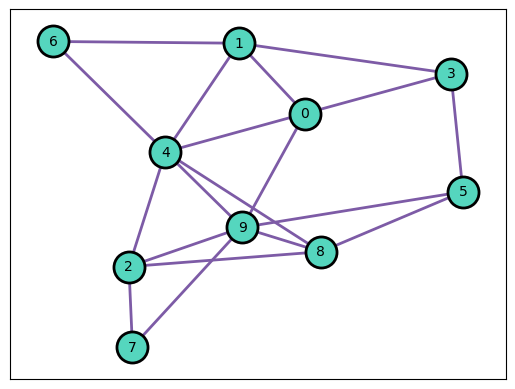

In [7]:
nG = SimilarityPredictor(3, similarity=similarity_common_neighbors).predict_all_links(G)
plot_graph(nG)

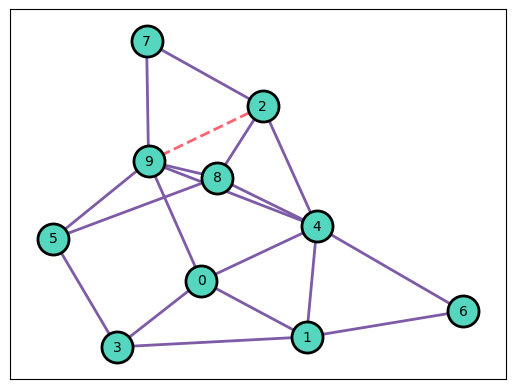

In [11]:
plot_predicted_graph(G, nG)

In `similarity_metrics.py`, we implemented 20 different metrics [3], so feel free to experiment below :)

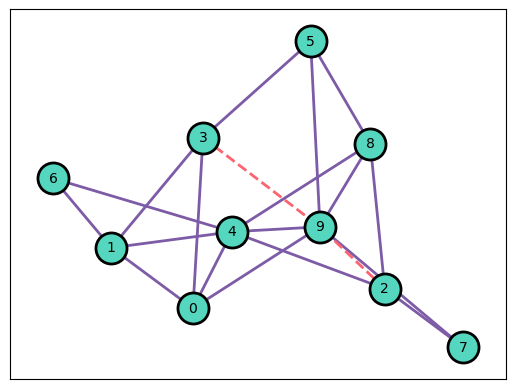

In [13]:
sim_fn = similarity_adamic_adar_index

nG = SimilarityPredictor(0.5, similarity=sim_fn).add_top_k_links(G, 3)
plot_predicted_graph(G, nG)

In [20]:
# Example statistics
stats = Stats()
print("Global clustering coefficient ground-truth graph: ", stats.global_clustering_coefficient(G))
print("Global clustering coefficient new graph", stats.global_clustering_coefficient(nG))
print("Average clustering coefficient ground-truth graph: ", stats.average_node_clustering_coefficient(G))
print("Average clustering coefficient new graph", stats.average_node_clustering_coefficient(nG))
for degree in range(1, 7):
    print(
        f"Degree-dependent clustering coefficient ground-truth graph with degree {degree}: ",
        stats.degree_dependent_clustering_coefficient(G, degree),
    )
    print(
        f"Degree-dependent clustering coefficient new graph with degree {degree}: ",
        stats.degree_dependent_clustering_coefficient(nG, degree),
    )

Global clustering coefficient ground-truth graph:  0.3888888888888889
Global clustering coefficient new graph 0.4230769230769231
Average clustering coefficient ground-truth graph:  0.4133333333333333
Average clustering coefficient new graph 0.4895238095238096
Degree-dependent clustering coefficient ground-truth graph with degree 1:  0
Degree-dependent clustering coefficient new graph with degree 1:  0
Degree-dependent clustering coefficient ground-truth graph with degree 2:  0.5
Degree-dependent clustering coefficient new graph with degree 2:  1.0
Degree-dependent clustering coefficient ground-truth graph with degree 3:  0.3333333333333333
Degree-dependent clustering coefficient new graph with degree 3:  0.4444444444444444
Degree-dependent clustering coefficient ground-truth graph with degree 4:  0.5
Degree-dependent clustering coefficient new graph with degree 4:  0.5
Degree-dependent clustering coefficient ground-truth graph with degree 5:  0.3
Degree-dependent clustering coefficient

## References
[1] Clauset, A., Moore, C., & Newman, M. E. (2008). Hierarchical structure and the prediction of missing links in networks. Nature, 453(7191), 98-101.

[2] Guimerà, R., & Sales-Pardo, M. (2009). Missing and spurious interactions and the reconstruction of complex networks. Proceedings of the National Academy of Sciences, 106(52), 22073-22078.

[3] Lü, L., & Zhou, T. (2011). Link prediction in complex networks: A survey. Physica A: statistical mechanics and its applications, 390(6), 1150-1170.

